In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

from keras import backend as K

from skimage import io
import os, random

In [4]:
filname = './fer2013/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('./fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

emotion                                             pixels     usage
0  emotion                                             pixels     Usage
1        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
2        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
3        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
4        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
5        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
6        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
7        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training
8        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...  Training
9        3  85 84 90 121 101 102 133 153 153 169 177 189 1...  Training

In [5]:
def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0])) # on met la colonne "émotions" dans Y
            X.append([int(p) for p in row[1].split()]) # on met toutes les autres valeurs dans X

    X, Y = np.array(X) / 255.0, np.array(Y) # pour normaliser les données car les librairies prennent des valeurs entre 0 et 1
    return X, Y

In [6]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [7]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
# Reformats the data to the format acceptable for convolutional layers
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [9]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(96, (11, 11), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(384, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(384, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(384, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax')) # Formats data to make them be like probabilities
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    
    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 96)        11712     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 256)       614656    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 384)       885120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 384)       1536      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 384)       0

In [10]:
path_model='model_filter.h5' # save model at this location after each epoch
K.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,0.001) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=32, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/20
1010/1010 [==============================] - 3735s 4s/step - loss: 1.8262 - accuracy: 0.2850 - val_loss: 1.5354 - val_accuracy: 0.3909
Epoch 2/20
1010/1010 [==============================] - 4211s 4s/step - loss: 1.4466 - accuracy: 0.4414 - val_loss: 1.5297 - val_accuracy: 0.4199
Epoch 3/20
1010/1010 [==============================] - 3810s 4s/step - loss: 1.2401 - accuracy: 0.5298 - val_loss: 1.3894 - val_accuracy: 0.4692
Epoch 4/20
1010/1010 [==============================] - 2743s 3s/step - loss: 1.0800 - accuracy: 0.5948 - val_loss: 1.1540 - val_accuracy: 0.5598
Epoch 5/20
1010/1010 [==============================] - 3000s 3s/step - loss: 0.9308 - accuracy: 0.6559 - val_loss: 1.1650 - val_accuracy: 0.5759
Epoch 6/20
1010/1010 [==============================] - 3067s 3s/step - loss: 0.7486 - accuracy: 0.7269 - val_loss: 1.1909 - val_accuracy: 0.5871
Epoch 7/20
1010/1010 [==============================] - 3795s 4s/step - loss: 0.5714 - accuracy: 0.7987 - val_loss: 1.2528 -

C:\Users\agnes\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


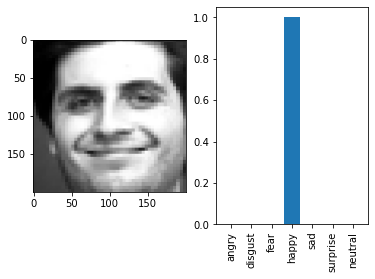

Expression Prediction: happy


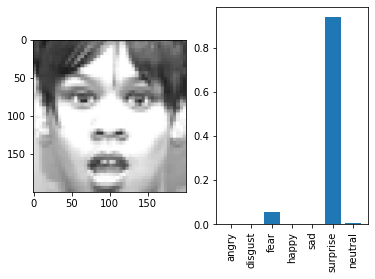

Expression Prediction: surprise


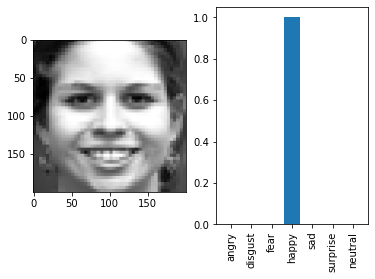

Expression Prediction: happy


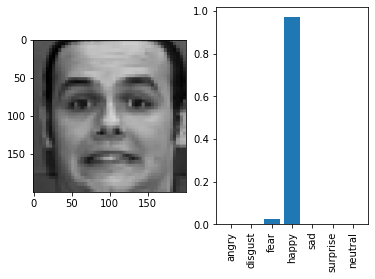

Expression Prediction: happy


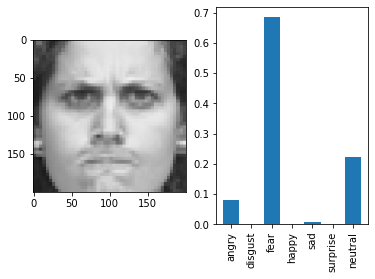

Expression Prediction: fear


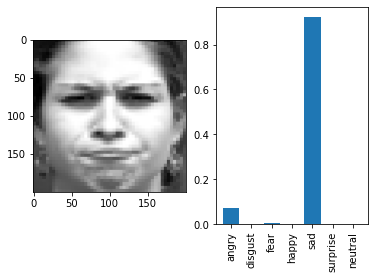

Expression Prediction: sad


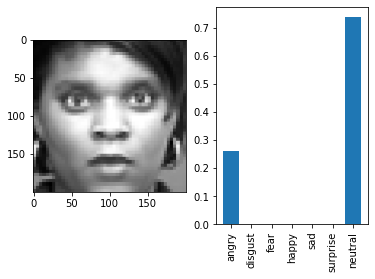

Expression Prediction: neutral


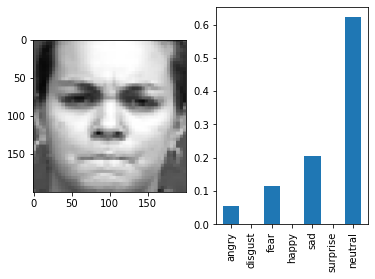

Expression Prediction: neutral


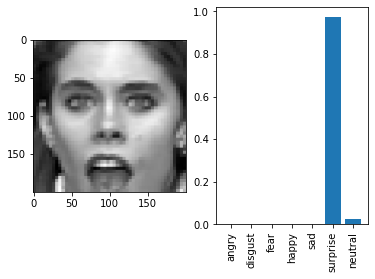

Expression Prediction: surprise


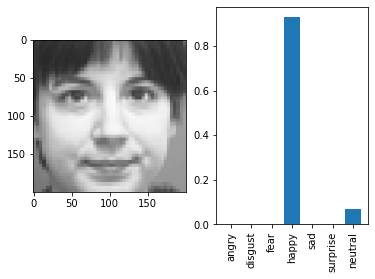

Expression Prediction: happy


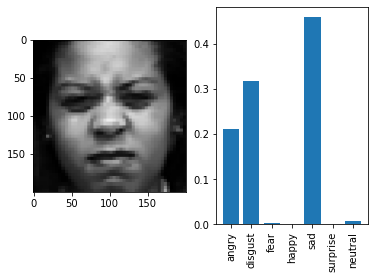

Expression Prediction: sad


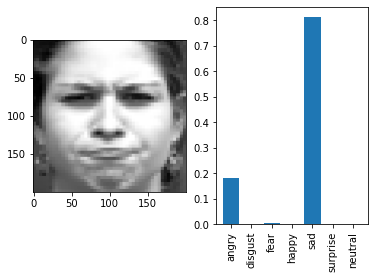

Expression Prediction: sad


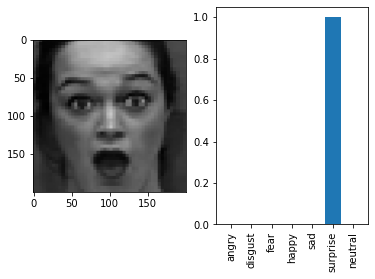

Expression Prediction: surprise


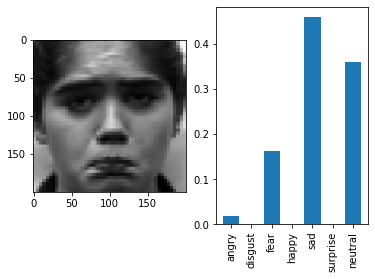

Expression Prediction: sad


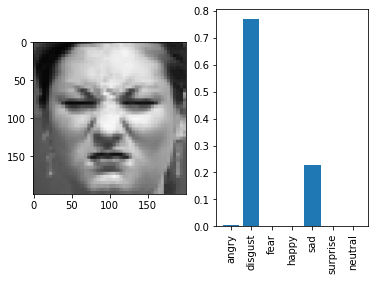

Expression Prediction: disgust


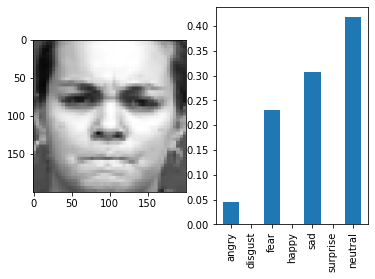

Expression Prediction: neutral


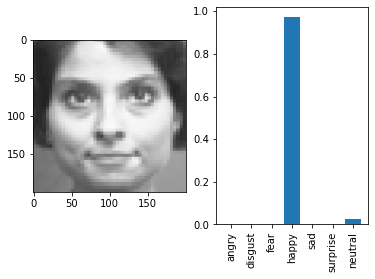

Expression Prediction: happy


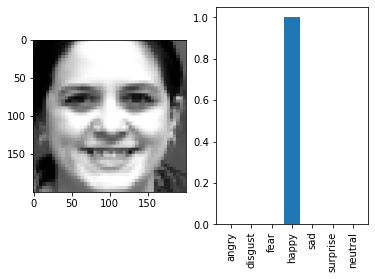

Expression Prediction: happy


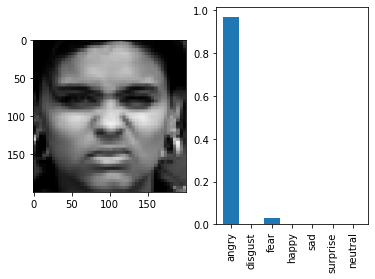

Expression Prediction: angry


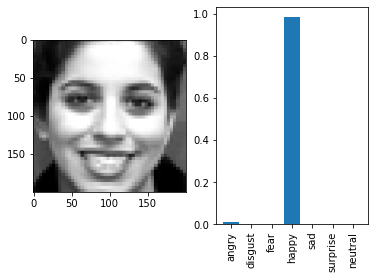

Expression Prediction: happy


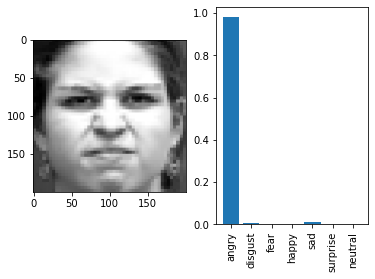

Expression Prediction: angry


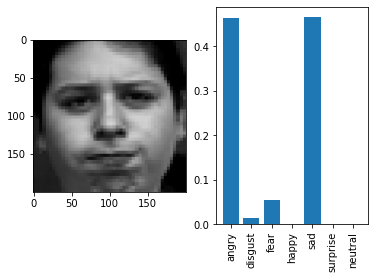

Expression Prediction: sad


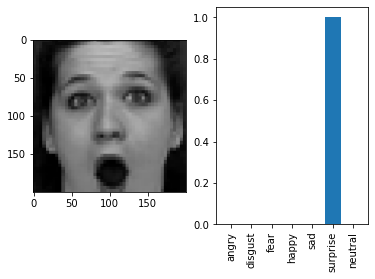

Expression Prediction: surprise


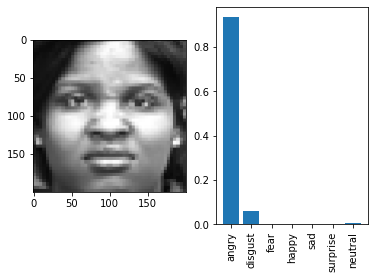

Expression Prediction: angry


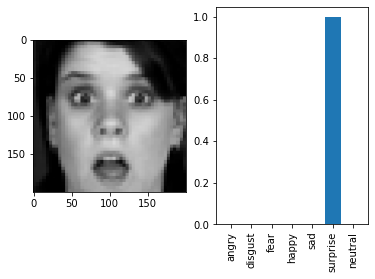

Expression Prediction: surprise


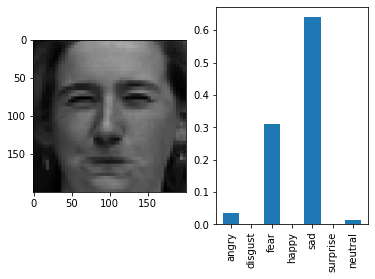

Expression Prediction: sad


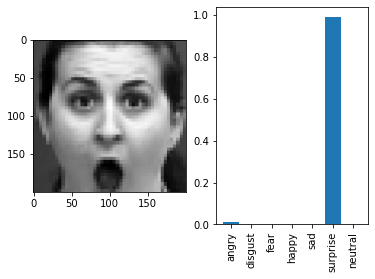

Expression Prediction: surprise


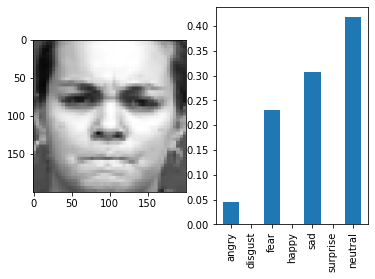

Expression Prediction: neutral


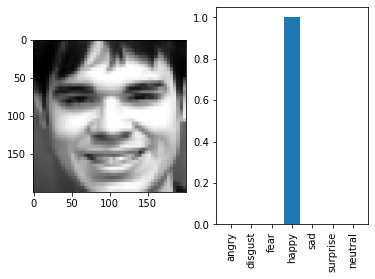

Expression Prediction: happy


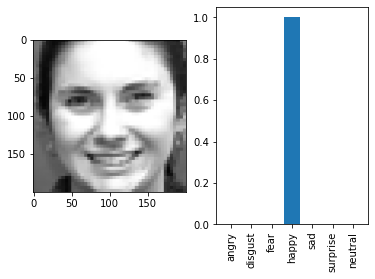

Expression Prediction: happy


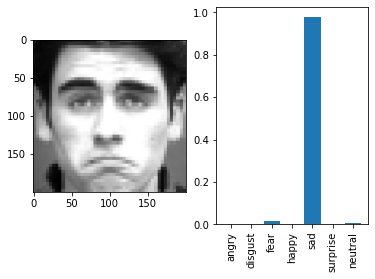

Expression Prediction: sad


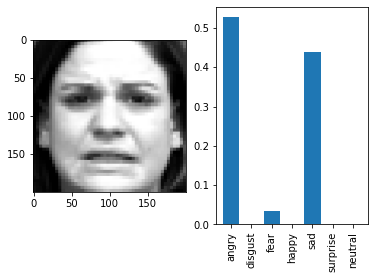

Expression Prediction: angry


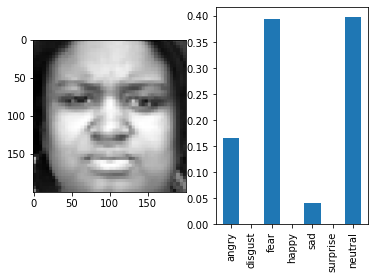

Expression Prediction: neutral


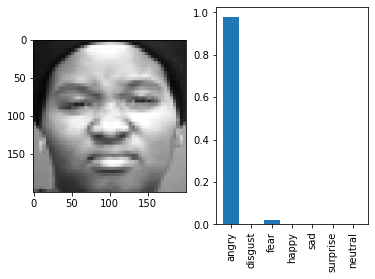

Expression Prediction: angry


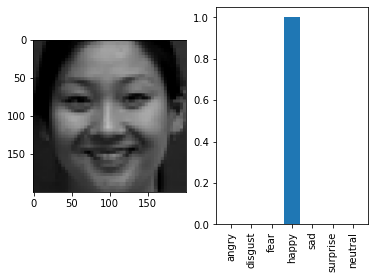

Expression Prediction: happy


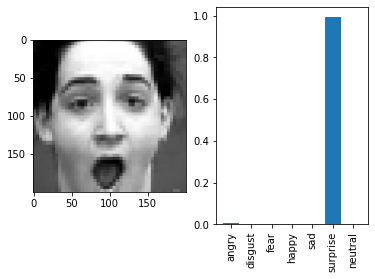

Expression Prediction: surprise


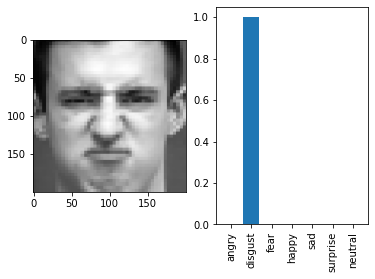

Expression Prediction: disgust


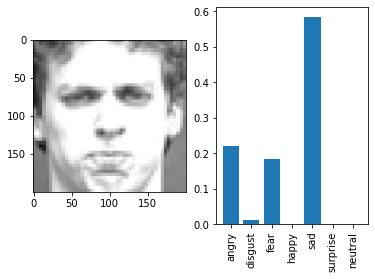

Expression Prediction: sad


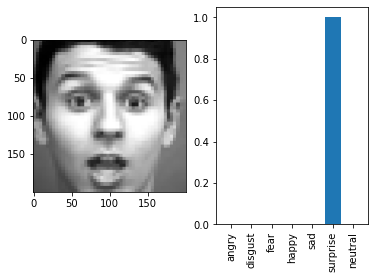

Expression Prediction: surprise


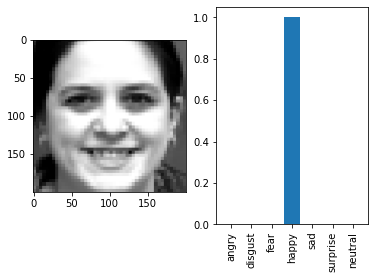

Expression Prediction: happy


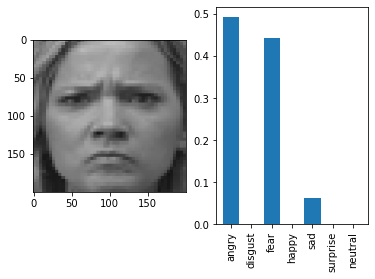

Expression Prediction: angry


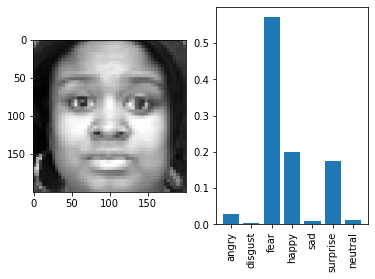

Expression Prediction: fear


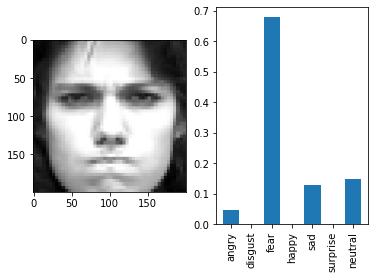

Expression Prediction: fear


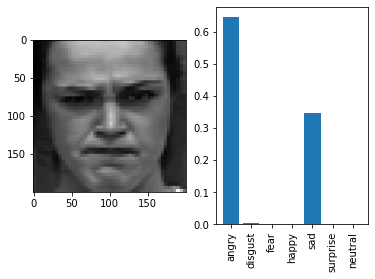

Expression Prediction: angry


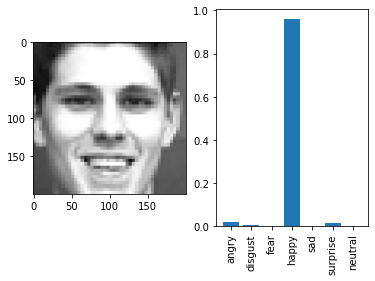

Expression Prediction: happy


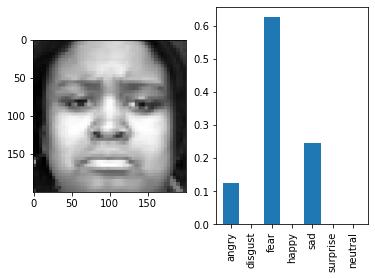

Expression Prediction: fear


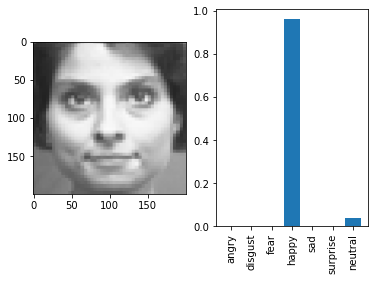

Expression Prediction: happy


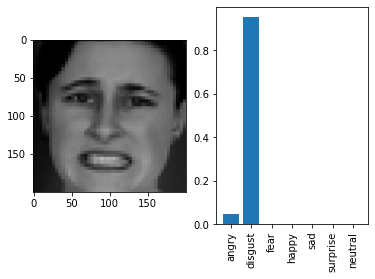

Expression Prediction: disgust


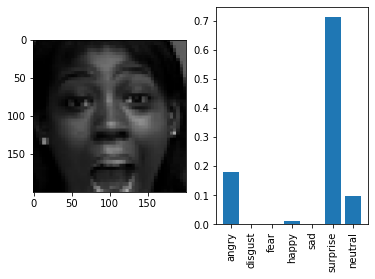

Expression Prediction: surprise


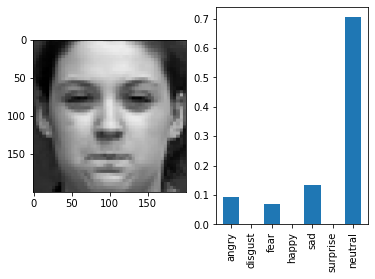

Expression Prediction: neutral


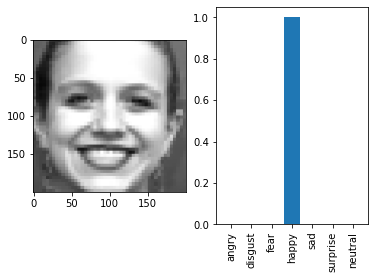

Expression Prediction: happy


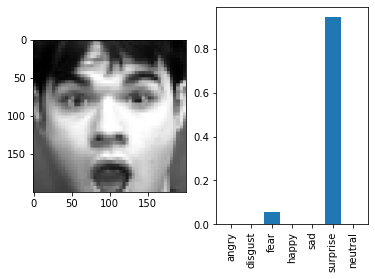

Expression Prediction: surprise


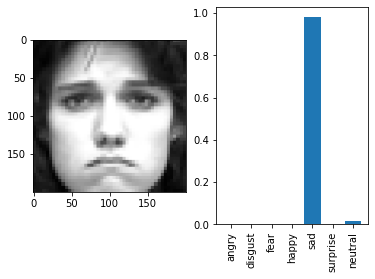

Expression Prediction: sad


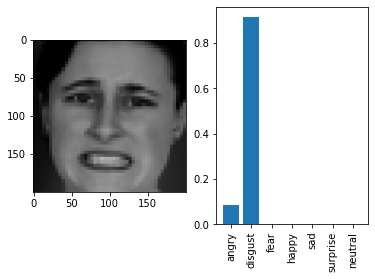

Expression Prediction: disgust


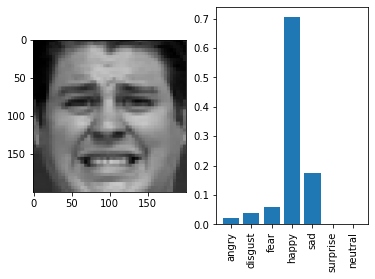

Expression Prediction: happy


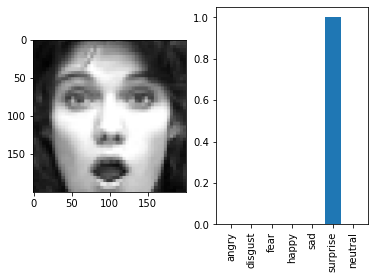

Expression Prediction: surprise


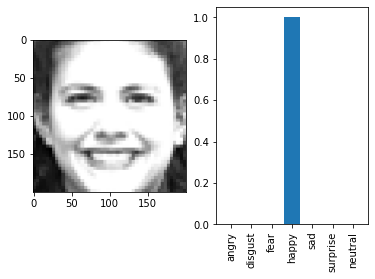

Expression Prediction: happy


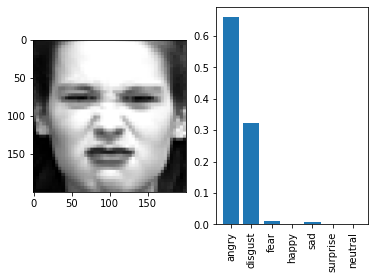

Expression Prediction: angry


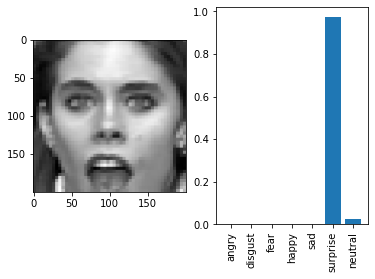

Expression Prediction: surprise


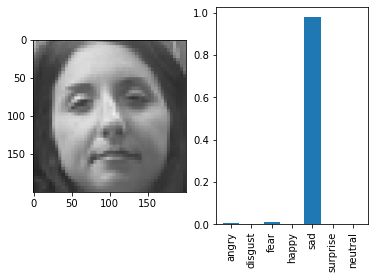

Expression Prediction: sad


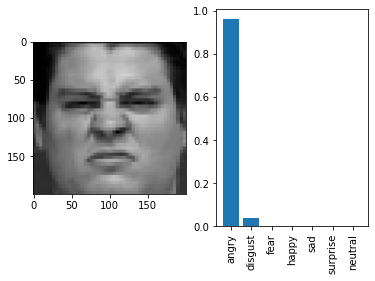

Expression Prediction: angry


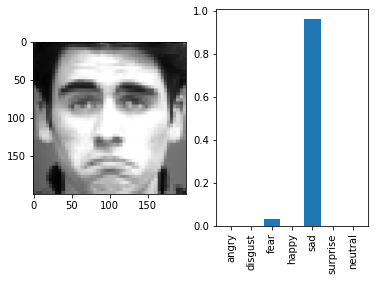

Expression Prediction: sad


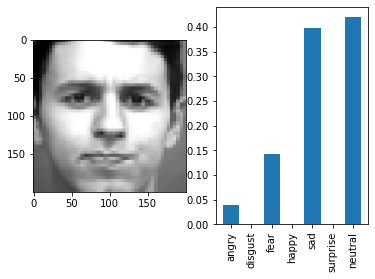

Expression Prediction: neutral


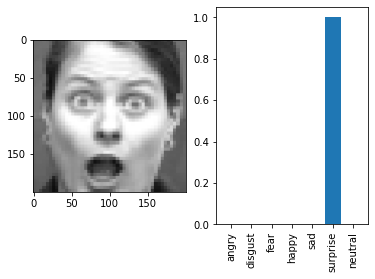

Expression Prediction: surprise


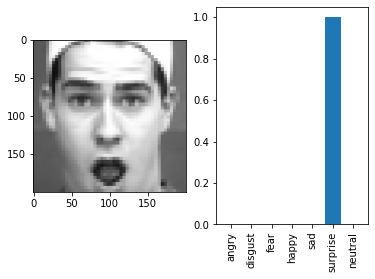

Expression Prediction: surprise


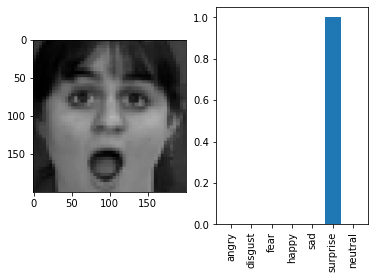

Expression Prediction: surprise


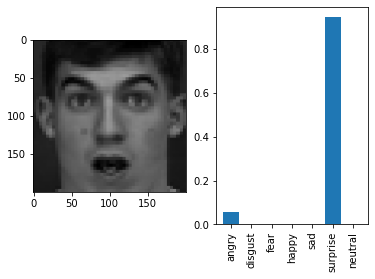

Expression Prediction: surprise


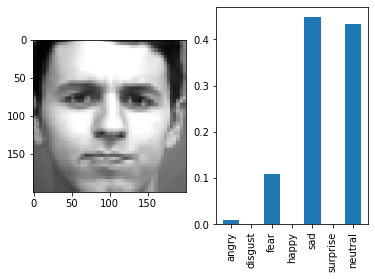

Expression Prediction: sad


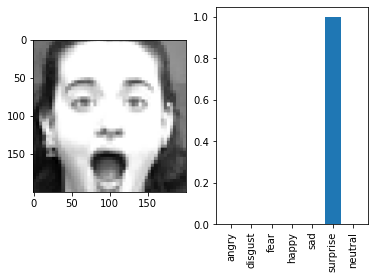

Expression Prediction: surprise


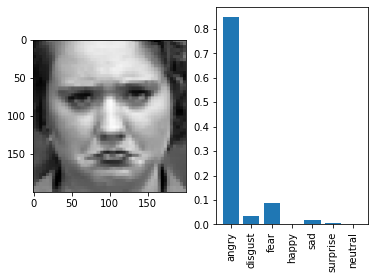

Expression Prediction: angry


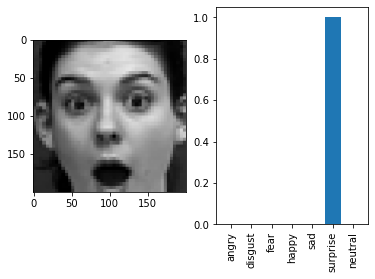

Expression Prediction: surprise


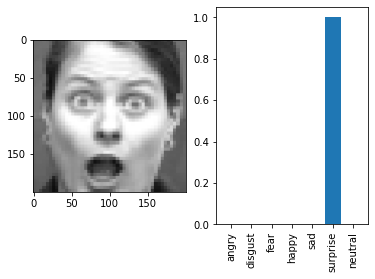

Expression Prediction: surprise


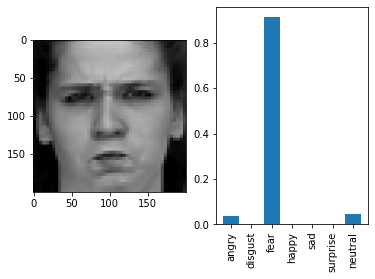

Expression Prediction: fear


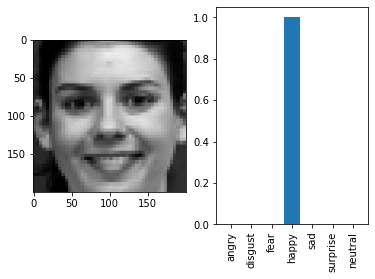

Expression Prediction: happy


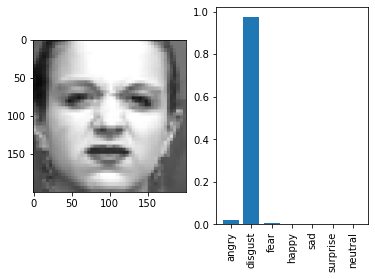

Expression Prediction: disgust


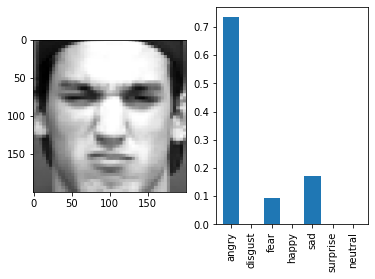

Expression Prediction: angry


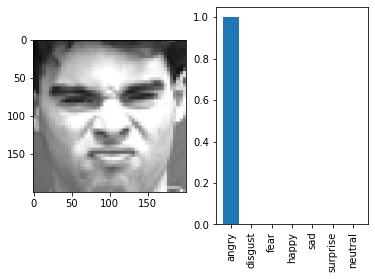

Expression Prediction: angry


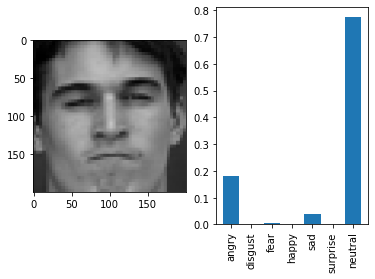

Expression Prediction: neutral


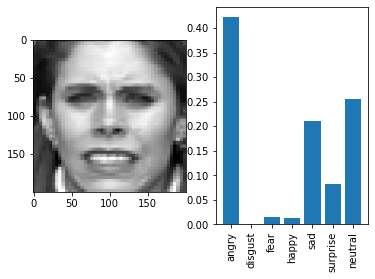

Expression Prediction: angry


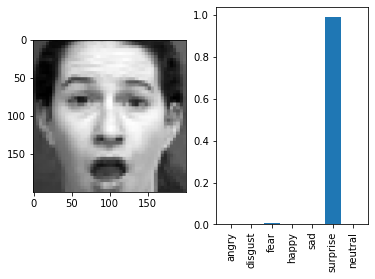

Expression Prediction: surprise


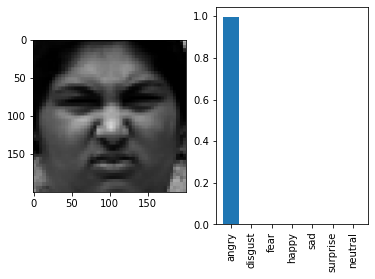

Expression Prediction: angry


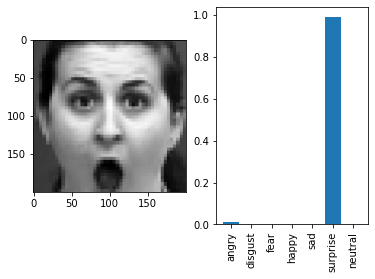

Expression Prediction: surprise


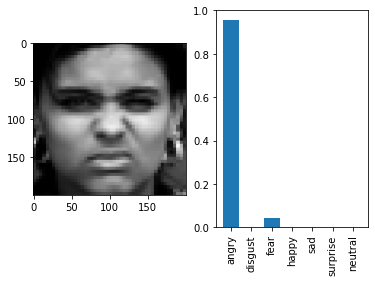

Expression Prediction: angry


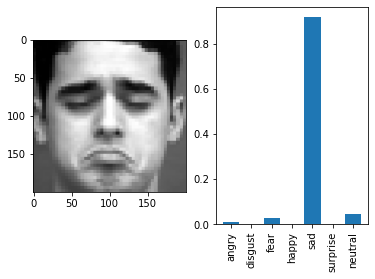

Expression Prediction: sad


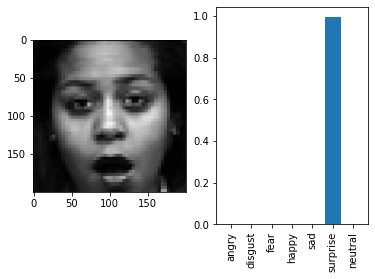

Expression Prediction: surprise


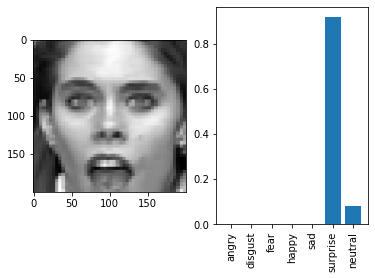

Expression Prediction: surprise


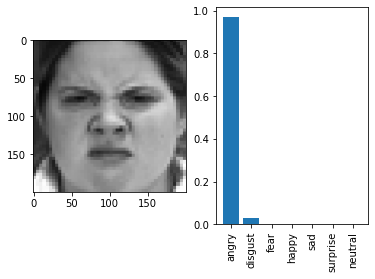

Expression Prediction: angry


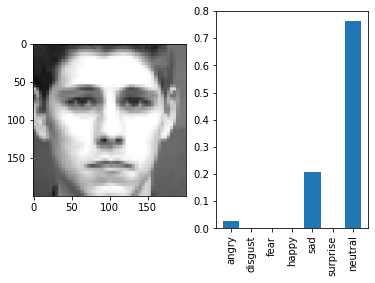

Expression Prediction: neutral


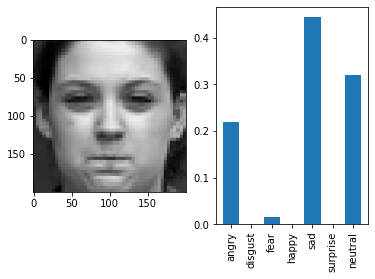

Expression Prediction: sad


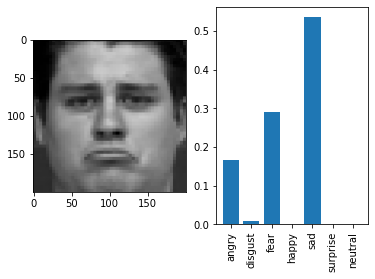

Expression Prediction: sad


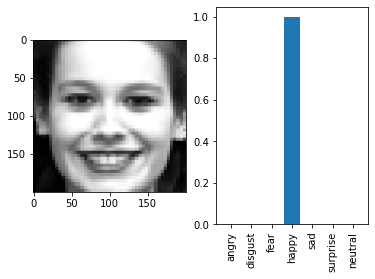

Expression Prediction: happy


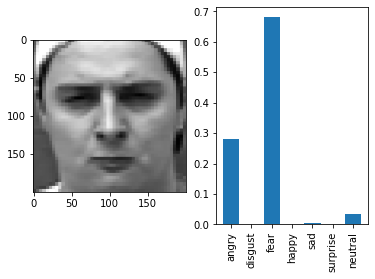

Expression Prediction: fear


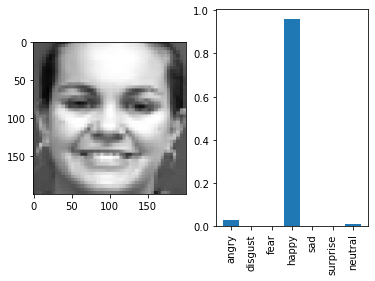

Expression Prediction: happy


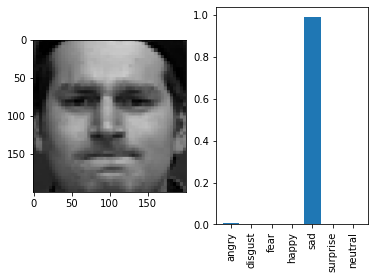

Expression Prediction: sad


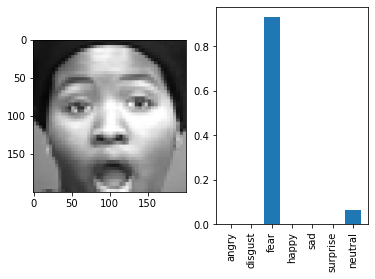

Expression Prediction: fear


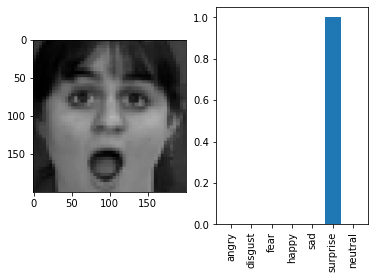

Expression Prediction: surprise


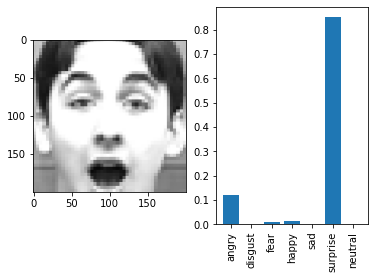

Expression Prediction: surprise


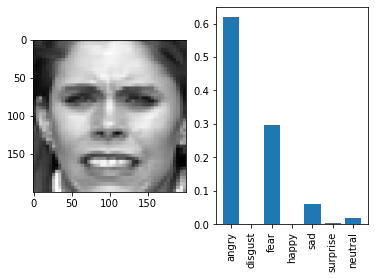

Expression Prediction: angry


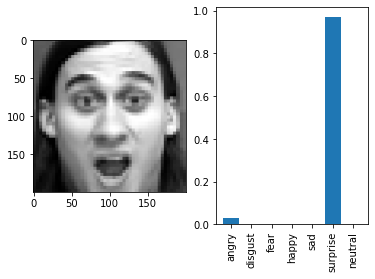

Expression Prediction: surprise


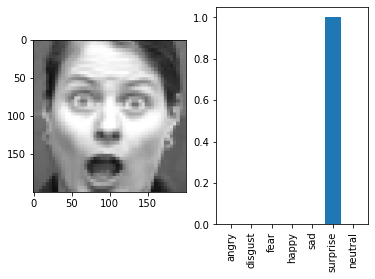

Expression Prediction: surprise


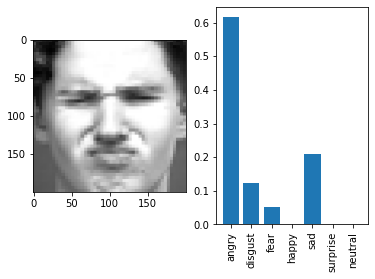

Expression Prediction: angry


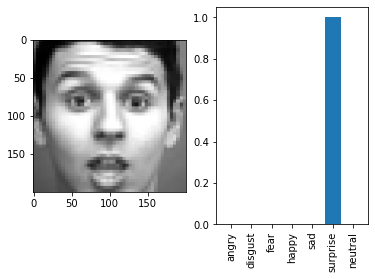

Expression Prediction: surprise


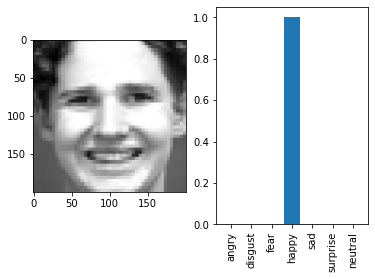

Expression Prediction: happy


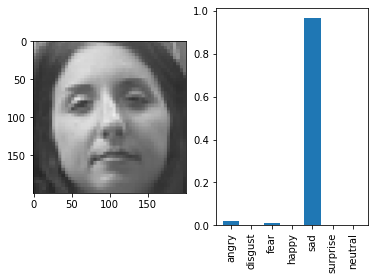

Expression Prediction: sad


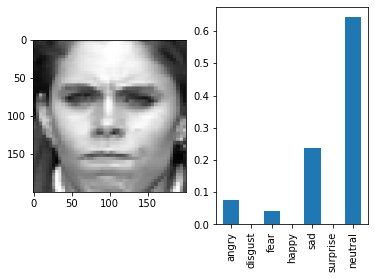

Expression Prediction: neutral


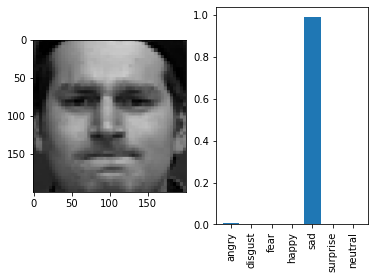

Expression Prediction: sad


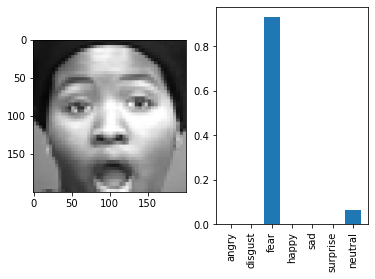

Expression Prediction: fear


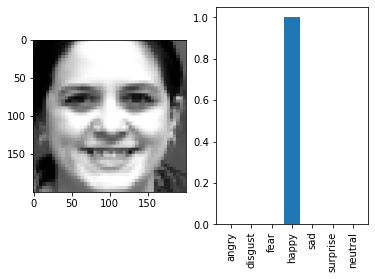

Expression Prediction: happy


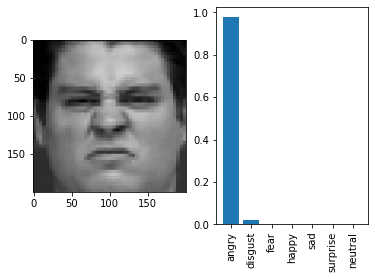

Expression Prediction: angry


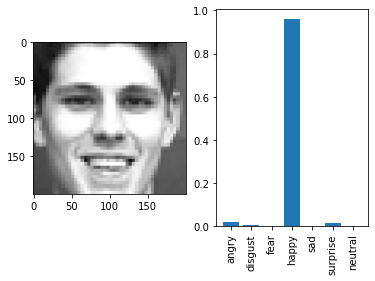

Expression Prediction: happy


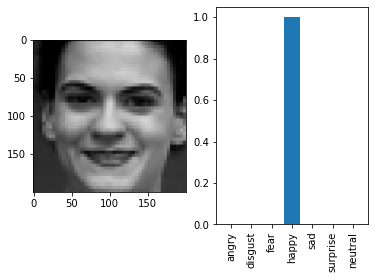

Expression Prediction: happy


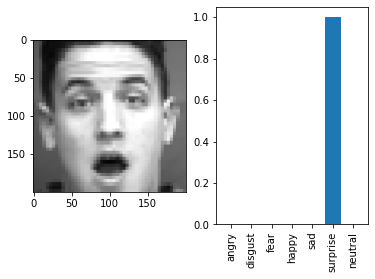

Expression Prediction: surprise


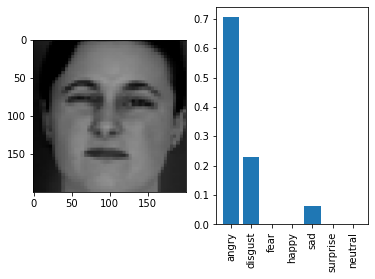

Expression Prediction: angry


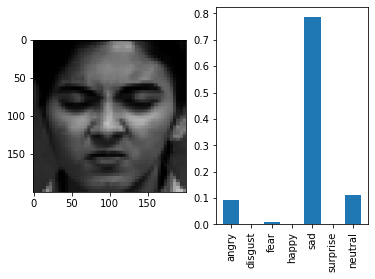

Expression Prediction: sad


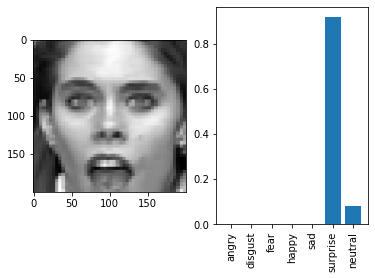

Expression Prediction: surprise


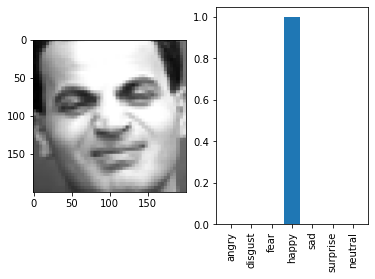

Expression Prediction: happy


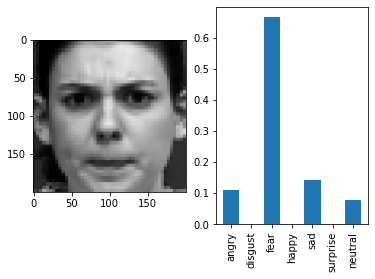

Expression Prediction: fear


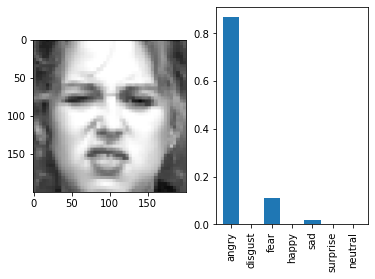

Expression Prediction: angry


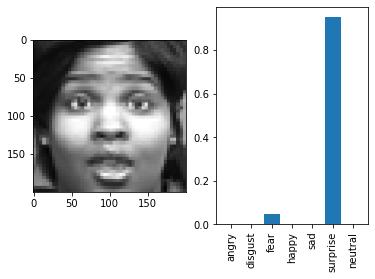

Expression Prediction: surprise


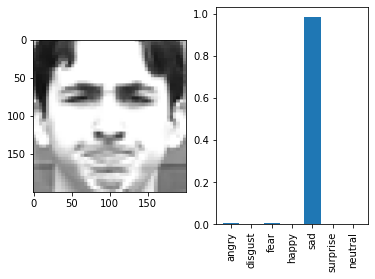

Expression Prediction: sad


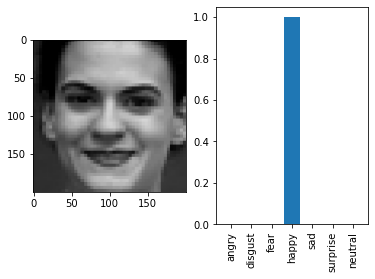

Expression Prediction: happy


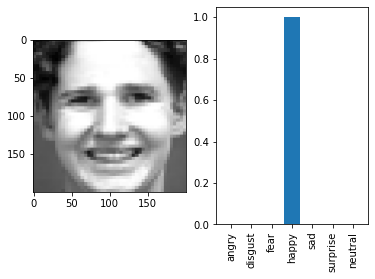

Expression Prediction: happy


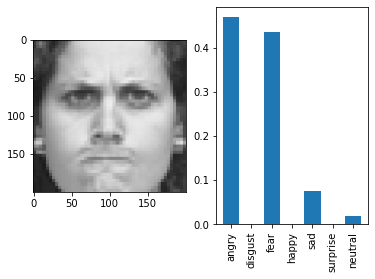

Expression Prediction: angry


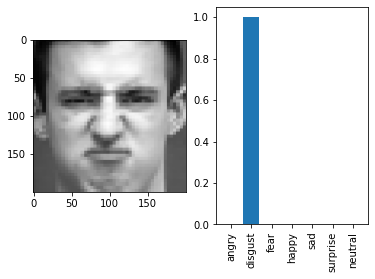

Expression Prediction: disgust


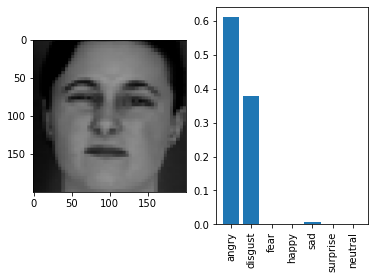

Expression Prediction: angry


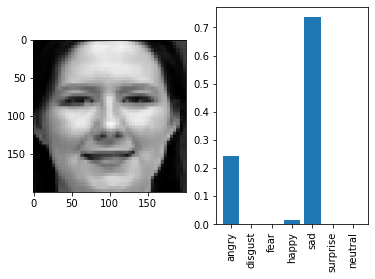

Expression Prediction: sad


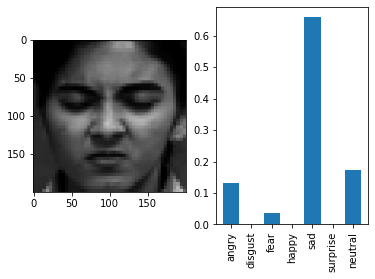

Expression Prediction: sad


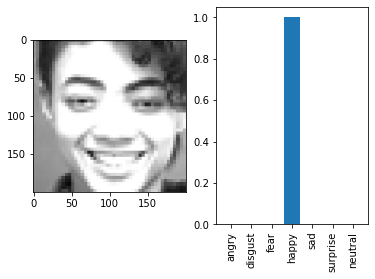

Expression Prediction: happy


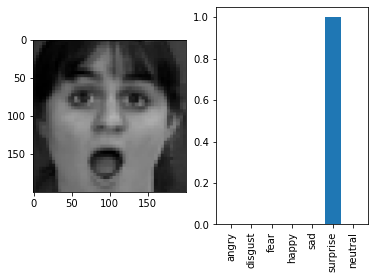

Expression Prediction: surprise


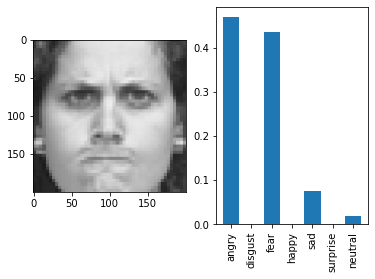

Expression Prediction: angry


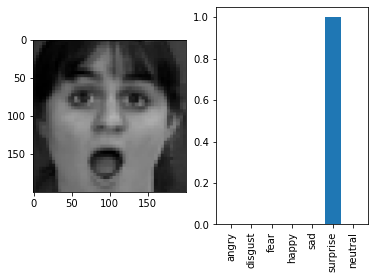

Expression Prediction: surprise


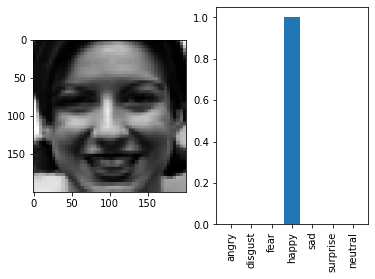

Expression Prediction: happy


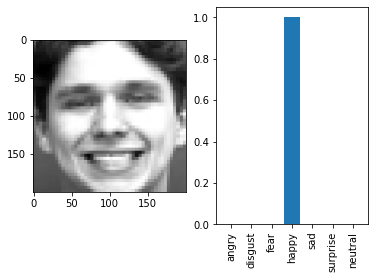

Expression Prediction: happy


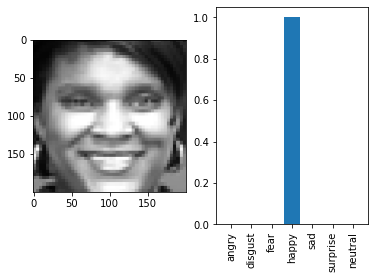

Expression Prediction: happy


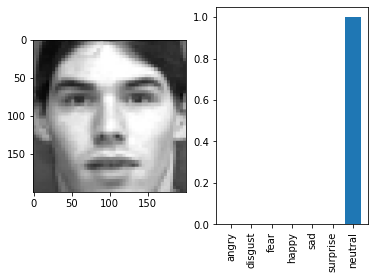

Expression Prediction: neutral


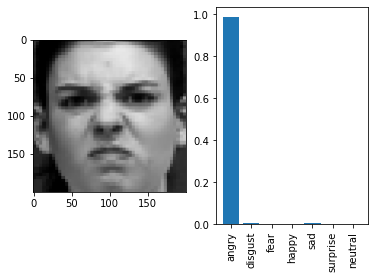

Expression Prediction: angry


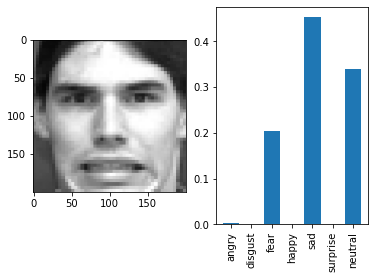

Expression Prediction: sad


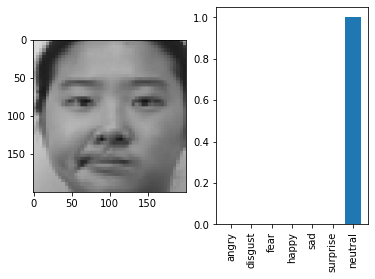

Expression Prediction: neutral


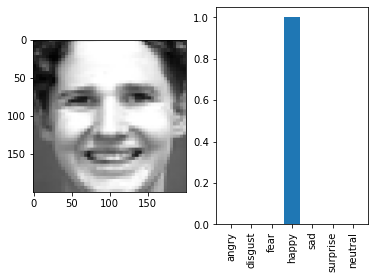

Expression Prediction: happy


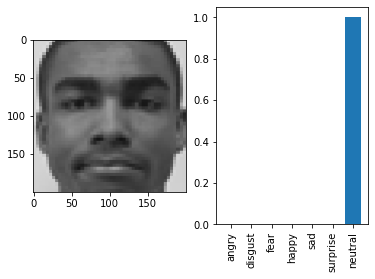

Expression Prediction: neutral


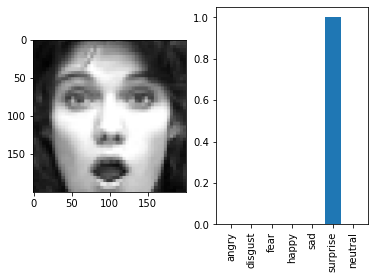

Expression Prediction: surprise


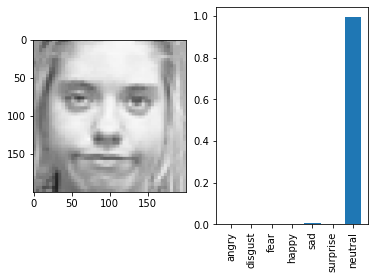

Expression Prediction: neutral


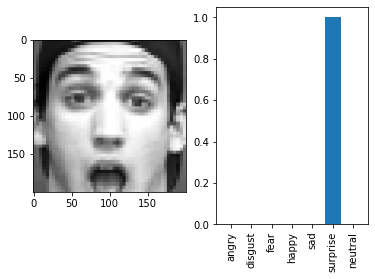

Expression Prediction: surprise


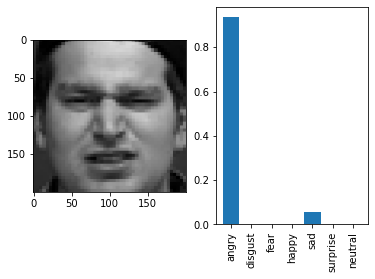

Expression Prediction: angry


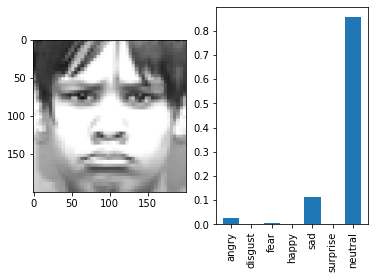

Expression Prediction: neutral


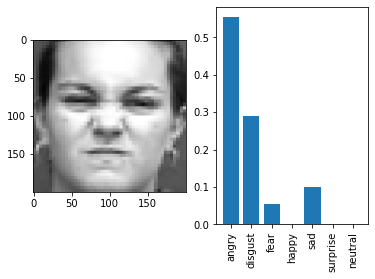

Expression Prediction: angry


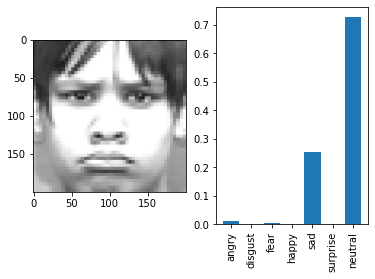

Expression Prediction: neutral


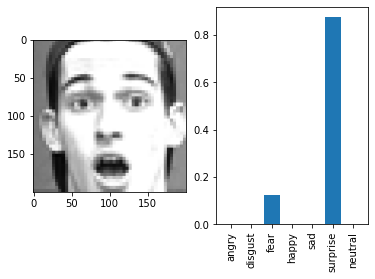

Expression Prediction: surprise


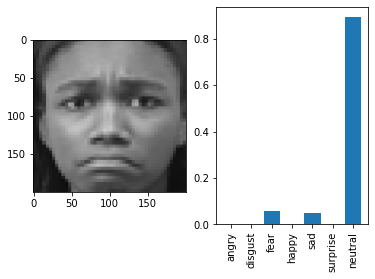

Expression Prediction: neutral


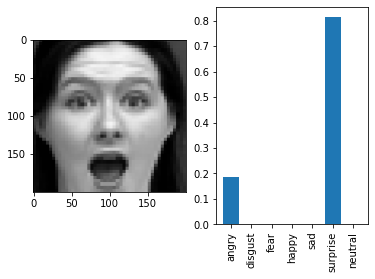

Expression Prediction: surprise


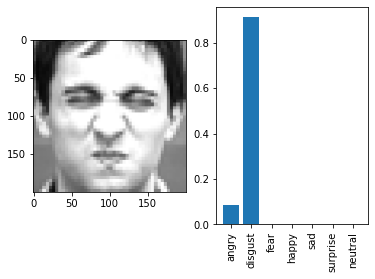

Expression Prediction: disgust


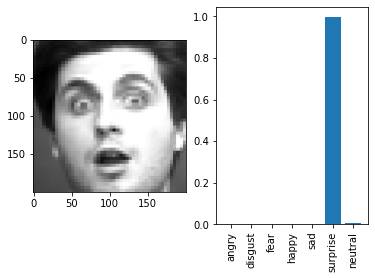

Expression Prediction: surprise


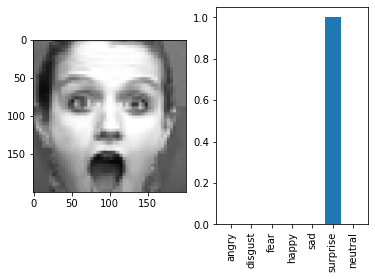

Expression Prediction: surprise


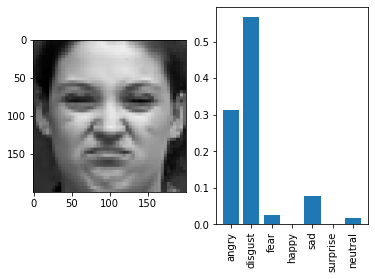

Expression Prediction: disgust


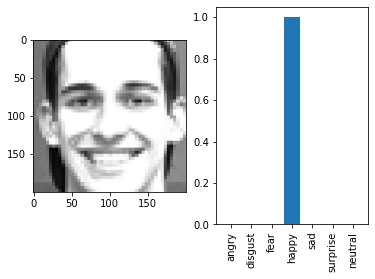

Expression Prediction: happy


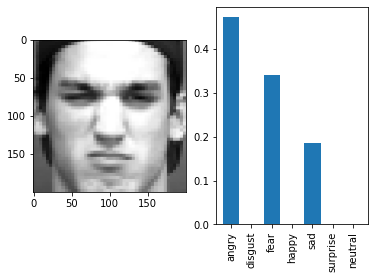

Expression Prediction: angry


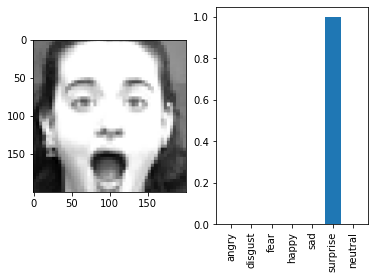

Expression Prediction: surprise


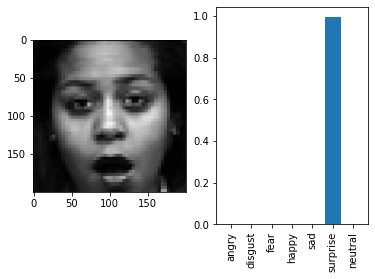

Expression Prediction: surprise


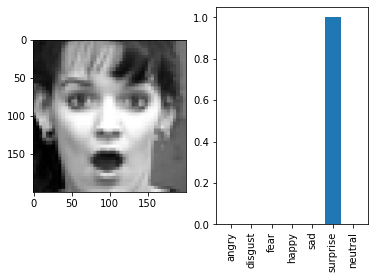

Expression Prediction: surprise


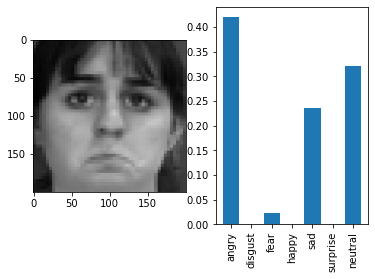

Expression Prediction: angry


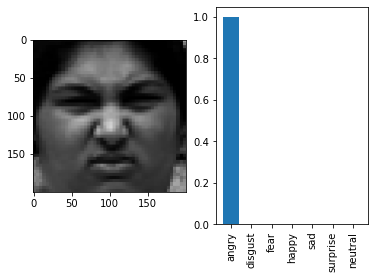

Expression Prediction: angry


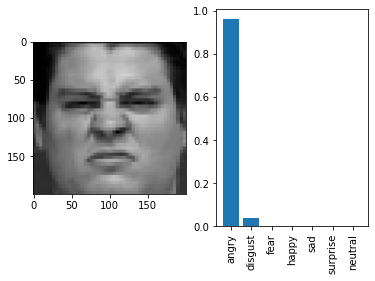

Expression Prediction: angry


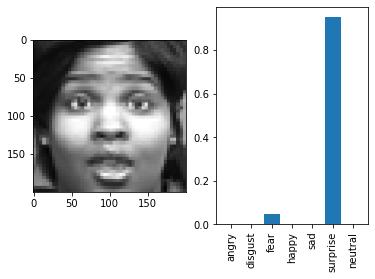

Expression Prediction: surprise


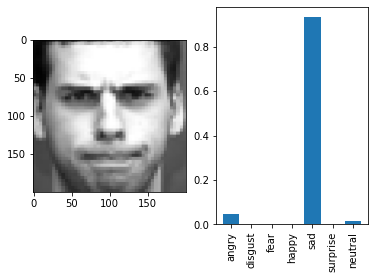

Expression Prediction: sad


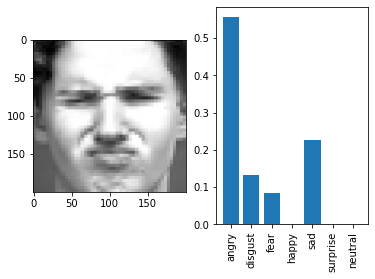

Expression Prediction: angry


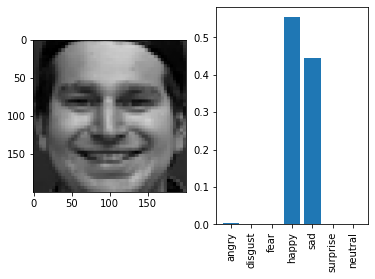

Expression Prediction: happy


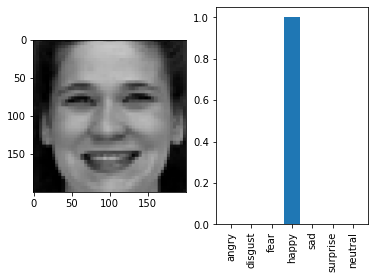

Expression Prediction: happy


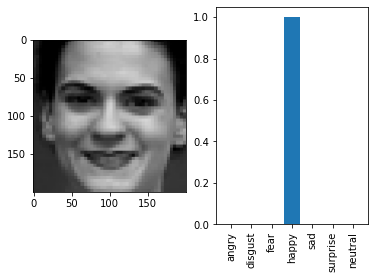

Expression Prediction: happy


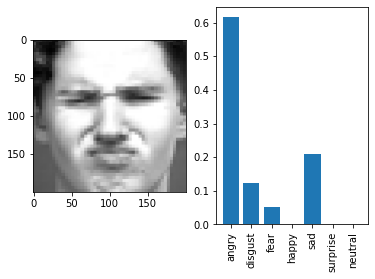

Expression Prediction: angry


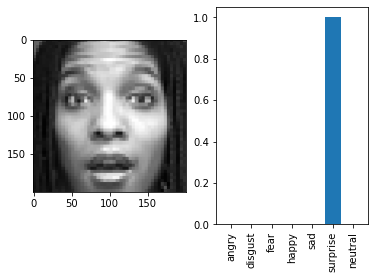

Expression Prediction: surprise


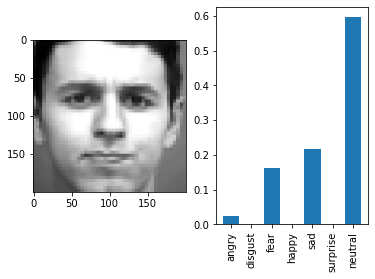

Expression Prediction: neutral


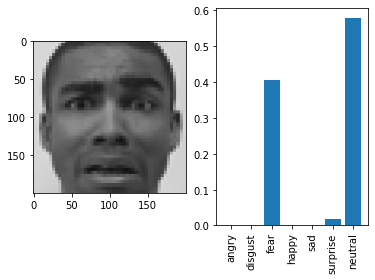

Expression Prediction: neutral


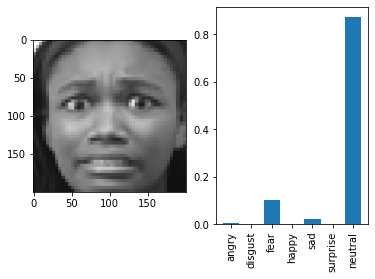

Expression Prediction: neutral


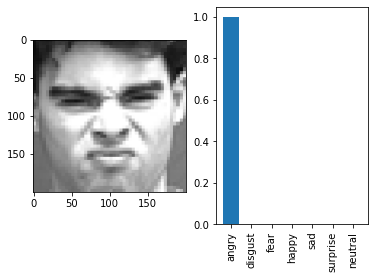

Expression Prediction: angry


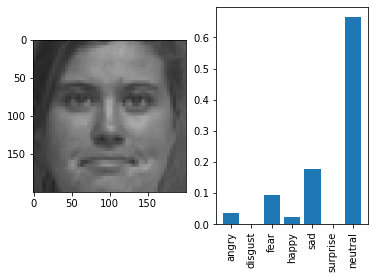

Expression Prediction: neutral


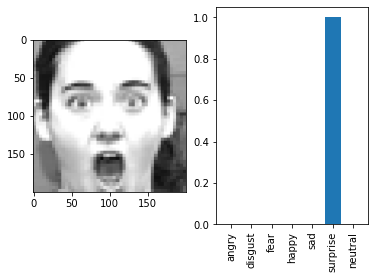

Expression Prediction: surprise


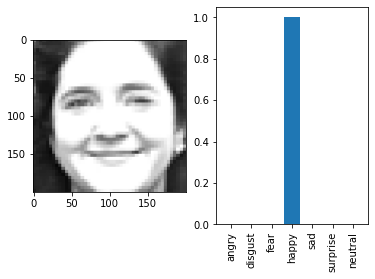

Expression Prediction: happy


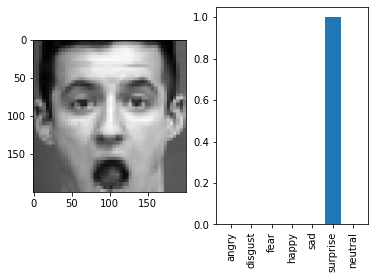

Expression Prediction: surprise


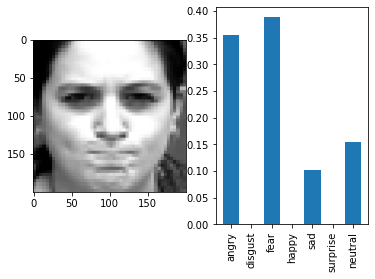

Expression Prediction: fear


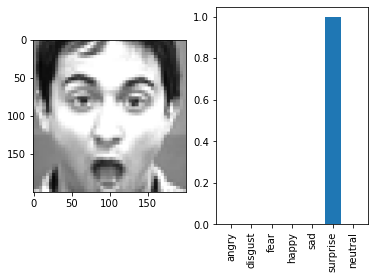

Expression Prediction: surprise


In [20]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
for i in range(0, 180):
    randimg = random.choice(os.listdir("./CK+48"))
    randimgpath = "./CK+48/" + randimg
    img = image.load_img(randimgpath, grayscale=True, target_size=(48, 48))
    show_img=image.load_img(randimgpath, grayscale=False, target_size=(200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255 # pour normaliser les données car les librairies prennent des valeurs entre 0 et 1

    custom = model.predict(x)

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);
    
    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(show_img)
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a=custom[0]
    m=a[0]
    for i in range(0,len(a)):
        if a[i]>=m:
            m=a[i]
            ind=i

    print('Expression Prediction:',objects[ind])

   

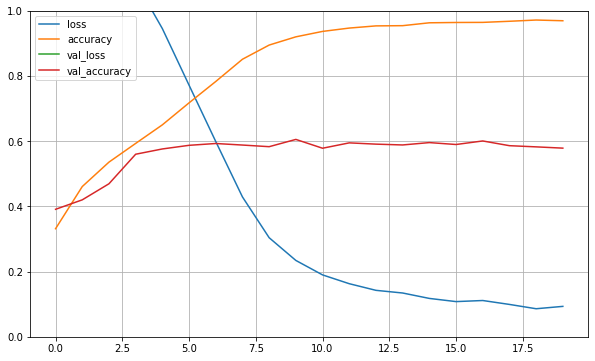

In [21]:
# Loss-Accuracy plot
pd.DataFrame(h.history).plot(figsize=(10, 6), ls='-')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
